In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
!head data/experimental/MitomiArchive/Reb1/Reb1_Data.txt

OligoNum	OligoSeq	Row	Col	Flag	Protein_button	DNA_button	DNA_chamber	Ratio	DNA_Final	Ratio_Final
882	GACTTTTTTAGAGAGAGATAGAGAGCCAGAGAGCGAGAGAGCTAGAGAGGCA	65	60	0.0	9659.0	20.0	1977.0	0.00207060772337	6.3191	0.0075646482687
1068	TGGTCAGGTGGTGAGGTGGTTAGGTGTATAGGTGTCCAGGTGTCGAGGTGTC	64	60	0.0	10551.0	1.0	131.0	9.47777461852e-05	-12.6809	-0.00683397568632
1062	GTCAGGTCGTGAGGTCGTTAGGTCTATAGGTCTCCAGGTCTCGAGGTCTCTA	63	60	0.0	10624.0	19.0	1884.0	0.00178840361446	5.3191	0.00550811967582
876	CTTTATGACTTTATTACTTTCAGACTTTCATACTTTCCCACTTTCCGACTTT	62	60	0.0	11029.0	0.0	2721.0	0.0	-13.6809	-0.00752465714292
870	TGCCGACTTGCCTACTTGCGCACTTGCGGACTTGCGTACTTGCTCACTTGCT	61	60	0.0	11324.0	11.0	2028.0	0.000971388202049	-2.6809	-0.000445782139923
0		60	60	0.0	11654.0	10.0	142.0	0.000858074480865	-3.6809	-0.0012715422909
0		59	60	0.0	11657.0	27.0	145.0	0.00231620485545	13.3191	0.00935440790903
1344	GGTGCCGCGGTTCCGCGTCGCCGCGTCTCCGCGTGGCCGCGTGTCCGCGTTG	58	60	0.0	11768.0	28.0	212.0	0.00237933378654	14.3191	0.00981

In [3]:
seqToRatio = {}
seqToDnaFinal = {}
seqToRatioFinal = {}
firstLine = True
with open("data/experimental/MitomiArchive/Reb1/Reb1_Data.txt") as inp:
    for line in inp:
        if line[0] == "0": continue
        if firstLine:
            firstLine = False
            continue
        num, Oligo, r, c, f, pb, dnab, dnac, ratio, dnafinal, rfinal= line.strip().split()
        seq = Oligo.upper()
        seqToRatio[seq] = float(ratio)
        seqToDnaFinal[seq] = float(dnafinal)
        seqToRatioFinal[seq] = float(rfinal)
        
seqs = []
ratios = []
dnaFinals = []
ratioFinals = []
for curr_seq in seqToRatio.keys():
    seqs.append(curr_seq)
    ratios.append(seqToRatio[curr_seq])
    dnaFinals.append(seqToDnaFinal[curr_seq])
    ratioFinals.append(seqToRatioFinal[curr_seq])

In [4]:
keyToFiles = {}
keyToFiles["reb1_chipexo"] = ("data/models/reb1_chipexo.h5",
                              "data/reb1_chipexo/idr.optimal_peak.narrowPeak.gz")

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]= "0,2"

In [6]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 546
out_pred_len = 255
test_chrms = ["chrX", "chrXI"]
keyToPeaks = {}
for key in keyToFiles: 
    peaks = []
    val0, val1 = keyToFiles[key]
    with gzip.open(val1, 'rt') as inp:
        for line in inp:
            chrm = line.strip().split('\t')[0]
            if chrm not in test_chrms:
                continue
            pStart = int(line.strip().split('\t')[1])
            summit = pStart + int(line.strip().split('\t')[-1])
            start = int(summit - (seq_len/2))
            end = int(summit + (seq_len/2))
            if len(GenomeDict[chrm][start:end].upper()) == seq_len:
                peaks.append(GenomeDict[chrm][start:end].upper())
    keyToPeaks[key] = peaks

In [7]:
from deeplift.dinuc_shuffle import dinuc_shuffle

ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
    # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [19]:
ratios = np.nan_to_num(ratios) 
dnaFinals = np.nan_to_num(dnaFinals) 
ratioFinals = np.nan_to_num(ratioFinals) 

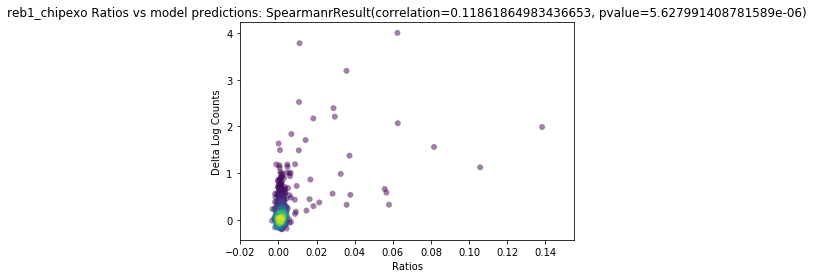

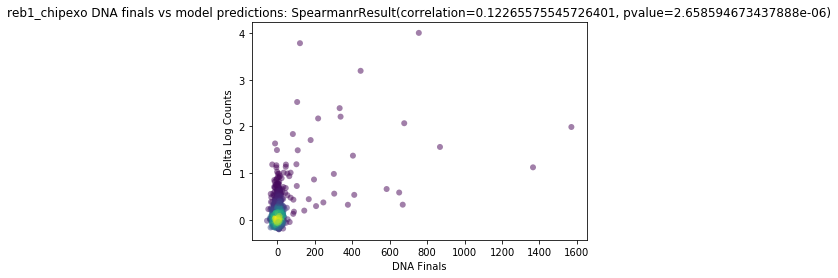

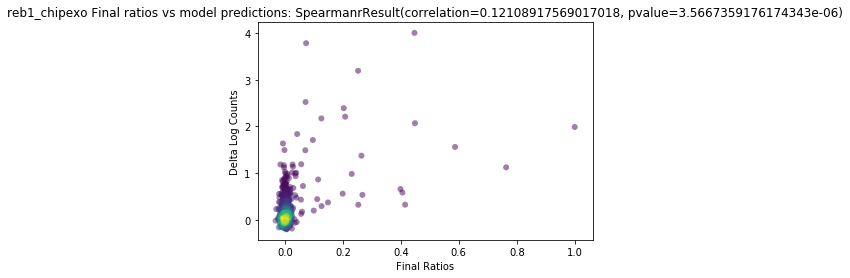

In [20]:
for key in keyToFiles:
    num_samples = min(len(keyToPeaks[key]), 100)
    print(key)
    val0, val1 = keyToFiles[key]
    with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
        model = load_model(val0)
    yvals = []
    seqToDeltaLogCount = {}
    for curr_seq in seqs:
        pre_seqs = []
        post_seqs = []
        insert_len = len(curr_seq)
        start = int((seq_len-insert_len)/2.0)
        indices = np.random.choice(len(keyToPeaks[key]), num_samples, replace=False)
        for idx in indices:
            pre_seq = dinuc_shuffle(keyToPeaks[key][idx])
            post_seq = pre_seq[:start] + curr_seq + pre_seq[start+insert_len:]
            pre_seqs.append(pre_seq)
            post_seqs.append(post_seq)
        pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
        post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
        seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
        yvals.append(seqToDeltaLogCount[curr_seq])

    K.clear_session()
    del model

#     json.dump(seqToDeltaLogCount,
#           codecs.open("data/preds/"+key+".json", 'w', encoding='utf-8'),
#           separators=(',', ':'),
#           sort_keys=True, indent=4)
    xy = np.vstack([ratios,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(ratios, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("Ratios")
    plt.ylabel("Delta Log Counts")
    plt.title(key+" Ratios vs model predictions: "+str(spearmanr(ratios, yvals)))
    plt.show()

    xy = np.vstack([dnaFinals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(dnaFinals, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("DNA Finals")
    plt.ylabel("Delta Log Counts")
    plt.title(key+" DNA finals vs model predictions: "+str(spearmanr(dnaFinals, yvals)))
    plt.show()

    xy = np.vstack([ratioFinals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(ratioFinals, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("Final Ratios")
    plt.ylabel("Delta Log Counts")
    plt.title(key+" Final ratios vs model predictions: "+str(spearmanr(ratioFinals, yvals)))
    plt.show()